# Deel 1

### Exploratory data analysis

### Achtergrond

We gaan werken aan het opsporen van Invasief ductaal carcinoom (Invasive ductal carcinoma, IDC). De oorspronkelijke dataset bestond uit 279 scans van borsten met en dergelijk carcicoom. Van deze oorspronkelijke data zijn 277.524 uitsneden gemaakt: 198.738 IDC-negatief and 78.786 IDC positief. Elke patiënt heeft z'n eigen directory die genoemd is naar het patiëntnummer. In deze directories vind je telkens weer twee andere directories: 0 en 1 met hierin de uiteindelijke uitsneden. De namen van al deze plaatjes hebben hetzelfde algemene formaat:

<patiennr>_idx5_<x-coord>_<y_coord>_class[01].png

De uitsneden die in de klasse 0 zitten betreffen gezond weefsel, de uitsneden in de directory 1 bevatten (delen van) tumoren. De bedoeling van deze opdracht is om een netwerk te creëren dat in staat is het gezonde van het ongezonde weefsteld te onderscheiden.

### Laad Libraries 

In [29]:
# Voor mappenbeheer
import os 
# Voor machine learning
import tensorflow as tf 
from sklearn.model_selection import train_test_split
# Voor visualisaties
import matplotlib.pyplot as plt  
# Voor datamanipulatie
import numpy as np  
# Voor laden en bewerken van afbeeldingen
from PIL import Image 

### Laad de dataset

We checken eerst het aantal patienten waar we mee werken:

In [20]:
data_path = "../data/idc_regular"
# Controleer aantal patiënten
patient_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
print(f"Aantal patiënten: {len(patient_dirs)}")

Aantal patiënten: 279


Er zijn inderdaad 279 directories aanwezig. We kiezen eerst 1 patient om de structuur van de data te bekijken. We gebruiken de library PIL met de module Image om RGB afbeeldingen (kleurenafbeeldingen) te openen en zetten het gelijk om in een array:

In [5]:
# Stel patiënt ID in
patient_id = '../data/idc_regular/8863'

# Lijsten voor positieve en negatieve afbeeldingen
imgs_positive = []
imgs_negative = []

# Vul de lijsten met bestanden
imgs_negative.extend(os.listdir(f'{patient_id}/0/'))
imgs_positive.extend(os.listdir(f'{patient_id}/1/'))

# Kies een willekeurige positieve afbeelding
idx = np.random.choice(len(imgs_positive))
img = Image.open(f'{patient_id}/1/{imgs_positive[idx]}') 

# Toon details van de afbeelding
print(img.format)
print(img.size)
print(img.mode)

# Zet afbeelding om naar een numpy-array en toon de vorm
print(np.asarray(img).shape)

PNG
(50, 50)
RGB
(50, 50, 3)


De output is PNG (50, 50) en RGB (50, 50, 3). De eerste twee values zijn hoogte en breedte en de derde input zijn de kleurkanalen. Er staat dus  (50 pixels, 50 pixels, [rood, blauw, groen]). 

### Missende waarden

We gaan nu de missende waarden checken van de dataset. Laten we het eerst doen voor 1 patient:

In [7]:
# Stel patiënt ID in
patient_id = '../data/idc_regular/8863'  # Specifieke patiëntenmap

# Lijsten voor positieve en negatieve afbeeldingen
imgs_positive = []
imgs_negative = []

# Vul de lijsten met bestanden
imgs_negative.extend(os.listdir(f'{patient_id}/0/'))
imgs_positive.extend(os.listdir(f'{patient_id}/1/'))

# Check hoeveel afbeeldingen er zijn
print(f"Aantal afbeeldingen in map 0 (gezond weefsel): {len(imgs_negative)}")
print(f"Aantal afbeeldingen in map 1 (ongezond weefsel): {len(imgs_positive)}")

# Kies een willekeurige positieve afbeelding en controleer
idx = np.random.choice(len(imgs_positive))
img = Image.open(f'{patient_id}/1/{imgs_positive[idx]}') 

# Zet afbeelding om naar een numpy-array en toon minimale en maximale waarden
img_array = np.asarray(img)
print(f"Minimale pixelwaarde: {np.min(img_array)}")
print(f"Maximale pixelwaarde: {np.max(img_array)}")

Aantal afbeeldingen in map 0 (gezond weefsel): 772
Aantal afbeeldingen in map 1 (ongezond weefsel): 207
Minimale pixelwaarde: 34
Maximale pixelwaarde: 250


In [27]:
# Laad een voorbeeldafbeelding
file_path = '../data/idc_regular/8863/1/8863_idx5_x1001_y801_class1.png'  # Pas dit aan
img = Image.open(file_path)
arr = np.array(img)

# Toon de unieke pixelwaarden in de afbeelding
print(np.unique(arr))


[ 41  53  55  56  60  61  62  63  65  66  67  68  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248]


In [23]:
# Pad naar een specifieke patiëntmap
specific_patient_id = '../data/idc_regular/8863'  # Pas aan naar de gewenste patiëntmap

# Lijsten voor afbeeldingen die voldoen aan de conditie
matching_images = []

# Waarde om te detecteren (bijvoorbeeld een bepaalde intensiteit)
detect_value = 255  # Pas dit aan naar jouw specifieke waarde

# Tolerantie voor het detecteren van waarden
tolerance = 1e-6

# Loop door de submappen '0' en '1' binnen de patiëntmap
for label in ['0', '1']:  # Map 0 voor gezond, 1 voor ongezond
    folder_path = os.path.join(specific_patient_id, label)
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            # Lees de afbeelding
            try:
                img = Image.open(file_path)
                arr = np.array(img)

                # Controleer per pixel op de detectiewaarde
                if np.any(np.isclose(arr, detect_value, rtol=tolerance, atol=tolerance)):
                    matching_images.append((file, label, os.path.basename(specific_patient_id)))

            except Exception as e:
                print(f"Kon bestand niet verwerken: {file_path}, fout: {e}")

# Toon resultaten
print(f"Afbeeldingen met detectiewaarde {detect_value} in patiëntmap {os.path.basename(specific_patient_id)}:")
for file, label, patient in matching_images:
    print(f"Bestand: {file}, Map: {label}, Patiëntmap: {patient}")

Afbeeldingen met detectiewaarde 255 in patiëntmap idc_regular:


### Verhouding gezonde en ongezonde weefsels

De breakdown tussen gezonde en ongezonde weefsels gaat ons helpen om beslissingen te maken hoe we de training data gaan splitsen. 

In [26]:
# hoofdmap
patient_id = '../data/idc_regular/'

# Lijsten voor positieve en negatieve afbeeldingen
imgs_positive = []
imgs_negative = []

# Loop door alle subdirectories in 'idc_regular'
for subdir in os.listdir(patient_id):
    subdir_path = os.path.join(patient_id, subdir)
    # Controleer of het een directory is
    if os.path.isdir(subdir_path):
        # Voeg bestanden toe aan de juiste lijst
        try:
            imgs_negative.extend([os.path.join(subdir_path, '0', file) 
                                  for file in os.listdir(os.path.join(subdir_path, '0'))])
            imgs_positive.extend([os.path.join(subdir_path, '1', file) 
                                  for file in os.listdir(os.path.join(subdir_path, '1'))])
        except FileNotFoundError:
            # Sla over als de subdirectory geen '0' of '1' bevat
            pass

# Controleer het aantal afbeeldingen
total_negative = len(imgs_negative)
total_positive = len(imgs_positive)

# Bereken de verhouding
ratio = total_negative / total_positive if total_positive > 0 else "Onbepaald"

# Toon de resultaten
print(f"Totaal aantal gezonde afbeeldingen: {total_negative}")
print(f"Totaal aantal ongezonde afbeeldingen: {total_positive}")
print(f"Verhouding gezonde tot ongezonde afbeeldingen: {ratio:.2f}:1" if total_positive > 0 else "Geen ongezonde afbeeldingen")
print(f"Percentage ongezonde afbeeldingen: {total_positive / (total_negative + total_positive) * 100:.2f}%" if total_positive > 0 else "0.00%")
print(f"Percentage gezonde afbeeldingen: {total_negative / (total_negative + total_positive) * 100:.2f}%" if total_positive > 0 else "100.00%")


Totaal aantal gezonde afbeeldingen: 198738
Totaal aantal ongezonde afbeeldingen: 78786
Verhouding gezonde tot ongezonde afbeeldingen: 2.52:1
Percentage ongezonde afbeeldingen: 28.39%
Percentage gezonde afbeeldingen: 71.61%


We zien hier dat we significant meer gezond weefsel hebben dan ongezond weefsel. Voor elke afbeelding van ongezond weefsel hebben we 2.52 afbeeldingen van gezond weefsel. De dataset bestaat voor 28.39% uit ongezond weefsel en voor 71.61% uit gezond weefsel.

### Ongezond weefsel per patient tov gemiddelde

Dan laten we nu de weefselpercentages zien van de scan, maar nu per patient en ten opzichte van het gemiddelde. 

In [18]:
# Pad naar de hoofdmap
patient_id = '../data/idc_regular/'

# Lijsten voor positieve en negatieve afbeeldingen
patient_data = {}

# Loop door alle subdirectories in 'idc_regular'
for subdir in os.listdir(patient_id):
    subdir_path = os.path.join(patient_id, subdir)
    # Controleer of het een directory is
    if os.path.isdir(subdir_path):
        try:
            # Haal positieve en negatieve afbeeldingen op
            imgs_negative = [os.path.join(subdir_path, '0', file) 
                             for file in os.listdir(os.path.join(subdir_path, '0'))]
            imgs_positive = [os.path.join(subdir_path, '1', file) 
                             for file in os.listdir(os.path.join(subdir_path, '1'))]

            # Bereken aantallen en percentage
            total_negative = len(imgs_negative)
            total_positive = len(imgs_positive)
            total_images = total_negative + total_positive
            percentage_positive = (total_positive / total_images * 100) if total_images > 0 else 0

            # Voeg data toe aan patient_data
            patient_data[subdir] = {
                "total_negative": total_negative,
                "total_positive": total_positive,
                "percentage_positive": percentage_positive
            }
        except FileNotFoundError:
            # Sla over als de subdirectory geen '0' of '1' bevat
            pass

# Bereken gemiddelde percentage ongezonde afbeeldingen
all_positive = sum(data["total_positive"] for data in patient_data.values())
all_images = sum(data["total_negative"] + data["total_positive"] for data in patient_data.values())
average_positive_percentage = (all_positive / all_images * 100) if all_images > 0 else 0

# Toon resultaten per patiënt
print("Resultaten per patiënt:")
for patient, data in patient_data.items():
    print(f"Patiënt: {patient}")
    print(f"  Totaal gezonde afbeeldingen: {data['total_negative']}")
    print(f"  Totaal ongezonde afbeeldingen: {data['total_positive']}")
    print(f"  Percentage ongezonde afbeeldingen: {data['percentage_positive']:.2f}%")
    comparison = "boven" if data['percentage_positive'] > average_positive_percentage else "onder"
    print(f"  Dit percentage is {comparison} het gemiddelde ({average_positive_percentage:.2f}%).")

# Toon algemene resultaten
print("\nAlgemene resultaten:")
print(f"Totaal aantal afbeeldingen: {all_images}")
print(f"Totaal ongezonde afbeeldingen: {all_positive}")
print(f"Gemiddelde percentage ongezonde afbeeldingen: {average_positive_percentage:.2f}%")


Resultaten per patiënt:
Patiënt: 10253
  Totaal gezonde afbeeldingen: 479
  Totaal ongezonde afbeeldingen: 70
  Percentage ongezonde afbeeldingen: 12.75%
  Dit percentage is onder het gemiddelde (28.39%).
Patiënt: 10254
  Totaal gezonde afbeeldingen: 772
  Totaal ongezonde afbeeldingen: 76
  Percentage ongezonde afbeeldingen: 8.96%
  Dit percentage is onder het gemiddelde (28.39%).
Patiënt: 10255
  Totaal gezonde afbeeldingen: 181
  Totaal ongezonde afbeeldingen: 91
  Percentage ongezonde afbeeldingen: 33.46%
  Dit percentage is boven het gemiddelde (28.39%).
Patiënt: 10256
  Totaal gezonde afbeeldingen: 351
  Totaal ongezonde afbeeldingen: 117
  Percentage ongezonde afbeeldingen: 25.00%
  Dit percentage is onder het gemiddelde (28.39%).
Patiënt: 10257
  Totaal gezonde afbeeldingen: 427
  Totaal ongezonde afbeeldingen: 208
  Percentage ongezonde afbeeldingen: 32.76%
  Dit percentage is boven het gemiddelde (28.39%).
Patiënt: 10258
  Totaal gezonde afbeeldingen: 422
  Totaal ongezonde a

### Gebieden het meest geinfecteerd met IDC

We gaan nu zien welke gebieden van de totale scan (x-y-coördinaten) het meest worden geïnfecteerd met IDC. Op basis van dit gegeven kunnen we iets zeggen over de tumoren.

In [ ]:
# Functie om x-coördinaat uit bestandsnaam te halen
def get_x(filename):
    if filename.startswith('.'):
        return 0
    t = filename.split('_')
    return int(t[2][1:])

# Functie om y-coördinaat uit bestandsnaam te halen
def get_y(filename):
    if filename.startswith('.'):
        return 0
    t = filename.split('_')
    return int(t[3][1:])

# Test de functies met een willekeurige positieve afbeelding
idx = np.random.choice(len(imgs_positive))
fn = f'{patient_id}/1/{imgs_positive[idx]}'
print(fn)
print(f'x: {get_x(fn)}, y: {get_y(fn)}')

### Visualisaties

We tonen nu een aantal uitsneden van zowel gezond als ongezond weefsel:

cancerous:


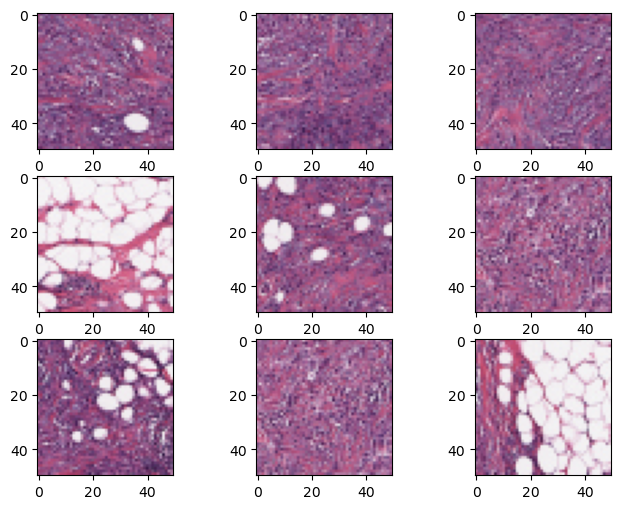

healthy:


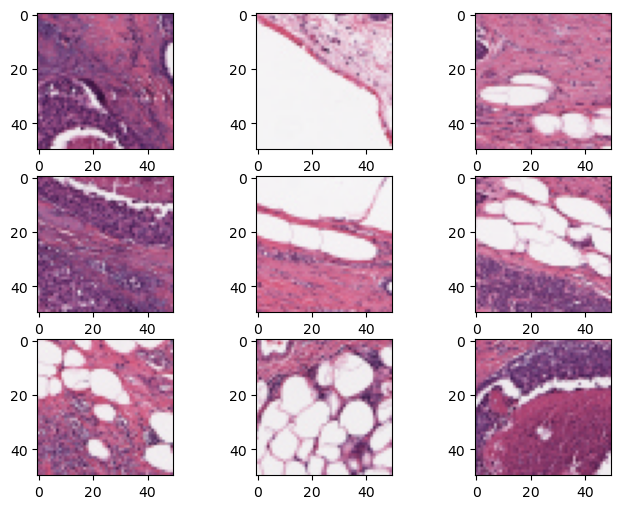

In [25]:
# Stel patiënt ID in
patient_id = '../data/idc_regular/8863'

# Lijsten voor positieve en negatieve afbeeldingen
imgs_positive = []
imgs_negative = []

# Vul de lijsten met bestanden
imgs_negative.extend(os.listdir(f'{patient_id}/0/'))
imgs_positive.extend(os.listdir(f'{patient_id}/1/'))

# Kies een willekeurige positieve afbeelding
idx = np.random.choice(len(imgs_positive))
img = Image.open(f'{patient_id}/1/{imgs_positive[idx]}') 

# Plot 3x3 positieve afbeeldingen (directory 1)
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
for r in range(3):
    for c in range(3):
        idx = np.random.choice(len(imgs_positive))
        img = Image.open(f'{patient_id}/1/{imgs_positive[idx]}')
        ax[c, r].imshow(img, cmap='gray')
print("cancerous:")
plt.show()

# Plot 3x3 negatieve afbeeldingen (directory 0)
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
for r in range(3):
    for c in range(3):
        idx = np.random.choice(len(imgs_negative))
        img = Image.open(f'{patient_id}/0/{imgs_negative[idx]}')
        ax[c, r].imshow(img, cmap='gray')
print("healthy:")
plt.show()

Bij het bekijken van weefselafbeeldingen valt op dat kankercellen doorgaans een intensere paarse kleur hebben, veroorzaakt door een hogere kernendichtheid (donkerpaarse kleuring door hematoxyline). Gezond weefsel bevat meer witte gebieden door extracellulaire ruimtes of vetweefsel en heeft een meer georganiseerde structuur. Deze kleurverschillen zijn nuttig voor classificatie tussen kankercellen en gezond weefsel. Dit klopt met de literatuur. 

# Deel 2

### Een model trainen

### splitsen van dataset 

In [30]:
# Verzamelen van alle patiëntmappen
patient_folders = [os.path.join(patient_id, subdir) for subdir in os.listdir(patient_id) if os.path.isdir(os.path.join(patient_id, subdir))]

# Splits patiënten in train- en testgroepen
train_patients, test_patients = train_test_split(patient_folders, test_size=0.2, random_state=42)

def collect_images(patient_paths):
    images, labels = [], []
    for patient_path in patient_paths:
        for label in ['0', '1']:
            folder_path = os.path.join(patient_path, label)
            if os.path.exists(folder_path):
                for file in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file)
                    images.append(file_path)
                    labels.append(int(label))  # Label is 0 (gezond) of 1 (ongezond)
    return images, labels

# Verzamel afbeeldingen en labels voor train- en testgroepen
train_images, train_labels = collect_images(train_patients)
test_images, test_labels = collect_images(test_patients)

### Data preprocessing

### Modeltraining

### Evaluatie